In [10]:
# importing custom game environment
from game import GameEnv
#imporrt relevant  python libraries
import math
import random
import pygame
from time import sleep
import numpy as np
import os
import time
from IPython import display
from collections import deque
from keras.models import Model, load_model,Sequential,load_model
from keras.layers import Input, Dense ,Conv2D,Flatten,MaxPooling2D
from keras.optimizers import Adam, RMSprop
import keras
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Hides game window during training.Showing window slows down training considerably
# os.environ["SDL_VIDEODRIVER"] = "dummy"

In [3]:
#initialize environemnt
env = GameEnv()

stateSize = len(env.reset())
stack_size =4 # Number of frames stacked

#actions
# 0 for no action
# 1 for go left
# 2 for go right
# 3 for shoot
action_size = 4 # 4 possible actions

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((stateSize), dtype=np.int) for i in range(stack_size)], maxlen=stack_size)
frameResize =  (40,30)    
 
def stack_frames(stacked_frames, frame, is_new_episode):
    #Stacks state data, based on number of frames - for including temporal information in training of the neural network 
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros(frameResize, dtype=np.int) for i in range(stack_size)], maxlen=stack_size)
        
        # Because we're in a new episode, copy the same frame 4x
        for i in range(stack_size):
          stacked_frames.append(frame)         
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=1)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=1) 
    # stacked_state = stacked_state.reshape((80,60,4))
    return stacked_state, stacked_frames
testState = env.reset() 
lastState,stacked_frames  = stack_frames(stacked_frames, testState, True)
print("stateShape",lastState.shape)
print("stacked",len(stacked_frames))


stateShape (102, 4)
stacked 4


In [4]:
from SumTree import SumTree
class Memory:   # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6

    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._getPriority(error)
        self.tree.add(p, sample) 

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

In [5]:
BATCH_SIZE = 128
class Brain:
    def __init__(self,actionCnt):
        self.stateCnt = lastState.shape
        self.actionCnt = actionCnt

        self.model = self._createModel()
        self.model_ = self._createModel()  # target network
    def save(self):
        self.model.save("weights.h5")
    def _createModel(self):
        model = Sequential()
        model.add(Flatten( input_shape=self.stateCnt))
        model.add(Dense(512,activation='relu'))    
        model.add(Dense(512, activation='relu'))
        model.add(Dense(512, activation='relu'))  
        model.add(Dense(512, activation='relu'))      
        model.add(Dense(units=self.actionCnt, activation='linear'))

        opt = RMSprop(lr=LEARNING_RATE)
        model.compile(loss="mse", optimizer=Adam(lr=0.00001))
        model.summary()
        return model
    def loadModel(self):
        self.model.load_weights("weights.h5")
        self.model_.load_weights("weights.h5")
    def train(self, x, y, epochs=1, verbose=0):
        self.model.fit(x, y, batch_size=BATCH_SIZE, epochs=1, verbose=verbose)

    def predict(self, s, target=False):
        if target:
            return self.model_.predict(s)
        else:
            return self.model.predict(s)

    def predictOne(self, s, target=False):
        return self.predict(s[np.newaxis,:], target).flatten()

    def updateTargetModel(self):
        self.model_.set_weights(self.model.get_weights())

In [6]:
MEMORY_CAPACITY = 100000

GAMMA = 0.99

MAX_EPSILON = 1
MIN_EPSILON = 0.01
HUBER_LOSS_DELTA = 2.0
LEARNING_RATE = 0.0001
EXPLORATION_STOP = 500000   # at this step epsilon will be 0.01
LAMBDA = - math.log(0.01) / EXPLORATION_STOP  # speed of decay

#no of steps, before copying weights to target network
UPDATE_TARGET_FREQUENCY = 500

class Agent:
    steps = 0
    epsilon = MAX_EPSILON

    def __init__(self, actionCnt):       
        self.actionCnt = actionCnt
        self.brain = Brain(actionCnt)
        self.memory = Memory(MEMORY_CAPACITY)
    def save(self):
        self.brain.save()  
    def loadTrain(self):
        self.brain.loadModel()  
    def act(self, s):
        if random.random() < self.epsilon:
            # print("random action")
            return random.randint(0, self.actionCnt-1)
        else:
            return np.argmax(self.brain.predictOne(s))

    def observe(self, sample):  # in (s, a, r, s_) format
        x, y, errors = self._getTargets([(0, sample)])
        self.memory.add(errors[0], sample)

        if self.steps % UPDATE_TARGET_FREQUENCY == 0:
            self.brain.updateTargetModel()

        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        # self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)

    def _getTargets(self, batch):
        no_state = np.zeros(lastState.shape)

        states = np.array([ o[1][0] for o in batch ])
        states_ = np.array([ (no_state if o[1][3] is None else o[1][3]) for o in batch ])

        p = agent.brain.predict(states)

        p_ = agent.brain.predict(states_, target=False)
        pTarget_ = agent.brain.predict(states_, target=True)

        x = np.zeros((len(batch), *lastState.shape))
        y = np.zeros((len(batch), self.actionCnt))
        errors = np.zeros(len(batch))
        
        for i in range(len(batch)):
            o = batch[i][1]
            s = o[0]; a = o[1]; r = o[2]; s_ = o[3]
            
            t = p[i]
            oldVal = t[a]
            if s_ is None:
                t[a] = r
            else:
                t[a] = r + GAMMA * pTarget_[i][ np.argmax(p_[i]) ]  # double DQN

            x[i] = s
            y[i] = t
            errors[i] = abs(oldVal - t[a])

        return (x, y, errors)

    def replay(self):    
        batch = self.memory.sample(BATCH_SIZE)
        x, y, errors = self._getTargets(batch)

        #update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])

        self.brain.train(x, y)

class RandomAgent:
    memory = Memory(MEMORY_CAPACITY)
    exp = 0

    def __init__(self, actionCnt):
        self.actionCnt = actionCnt

    def act(self, s):
        return random.randint(0, self.actionCnt-1)

    def observe(self, sample):  # in (s, a, r, s_) format
        error = abs(sample[2])  # reward
        self.memory.add(error, sample)
        self.exp += 1

    def replay(self):
        pass


In [7]:
randomAgent = RandomAgent(4)
agent = Agent(4)
#to resume training, uncomment this line
#agent.loadTrain()
# agent.epsilon = 0.001

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 408)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               209408    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 2052      
Total params: 999,428
Trainable params: 999,428
Non-trainable params: 0
________________________________________________

In [8]:

#-------------------- ENVIRONMENT ---------------------
#training
#create environment
env = GameEnv(0)
agentEpisodes=100000
randomAgentEpisodes = 50 
agent.memory = randomAgent.memory

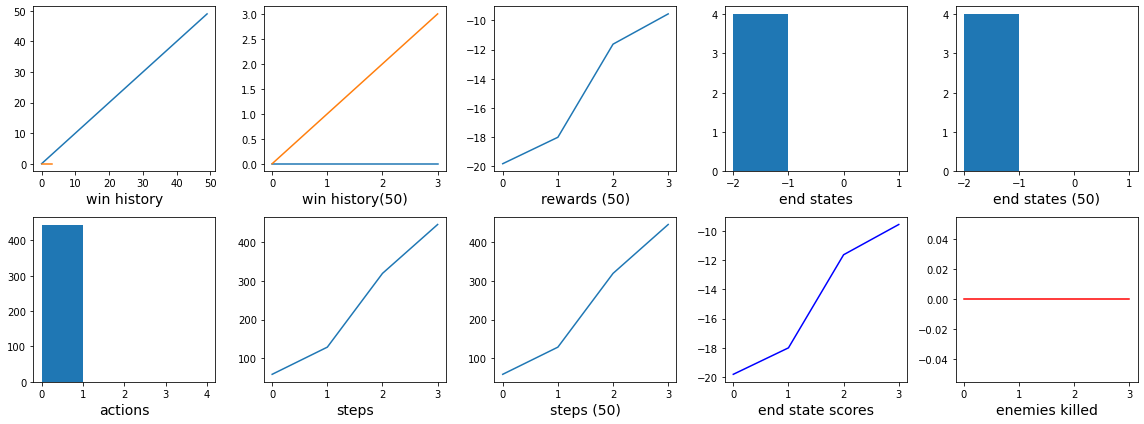

KeyboardInterrupt: 

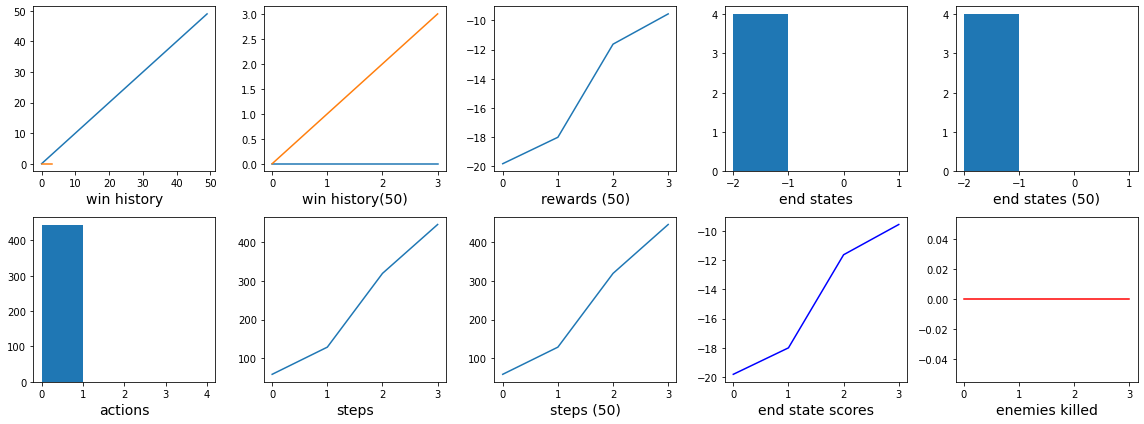

In [19]:
agent.steps = 0
#agen runs
invasionScores =[]
winScores =[]
deadScores = []
score_history=[]
winsHistory = []
stepsTracker = []
deads = []
hist = []
wins = 0
lastWins=0
for i in range(agentEpisodes):
    done = False
    #reset environment and get first frame
    frame = env.reset()
    frame,t1,t2,t3 =env.step(0)
   
    env.bullets=90
    
    actions = []        
    #set initial state
    s ,stacked_frames= stack_frames(stacked_frames, frame, True)
    R = 0
    startTime = time.time()
    while not done:
        
        #set custom rewards
        #reward for shoting an alien
        env.enemyShotReward =0.3* (env.enemyBlock.numDead)* ((2000-env.steps)/2000) 
        #reward for progressing to a killing all enemies        
        env.allDeadReward = 1
        #reward for avoiding getting shot by enemy bullets 
        env.enemyMissedReward = 0.1
           
                   
        a = agent.act(s)          
        actions.append(a)
        #simulate action
        frame, r, done, win = env.step(a)
        ns ,stacked_frames= stack_frames(stacked_frames, frame, True)
        if(done):
            ns = None
        #collect samples 
        agent.observe( (s, a, r, ns) )

        #start actual training after collecting a few samples
        if(agent.steps>1000000):
            agent.replay()
        R+=r
        #set nextstate as now the current state
        s=ns
        
    #record metrics
    score=R
    steps=env.steps
    if(win==1):
      wins+=win
      winScores.append(R)
      lastWins+=abs(win)
    if(win==-2):
      deadScores.append(R)
    if(win==-1):
      invasionScores.append(R)
    if(win!=0):
      #invasion
      hist.append(win)
    dur = time.time()-startTime
    if(env.enemyBlock.numDead==30):
        agent.save()
    winsHistory.append(wins)
    stepsTracker.append(steps)  
    score_history.append(score)   
    deads.append(env.enemyBlock.numDead)
    
    #graphs
    if(i%50==0):
      lastWins = 0
    
  
    graphLimit = 50
  
    print(f"episode {i} score {score} steps={steps} wins={wins} numDead={env.enemyBlock.numDead} percent={wins/(i+1)} last50 ={lastWins/(i%50+1)} avg score { np.mean(score_history[max(0, i-100):(i+1)])} time {dur} ")
    print("under shot reward",env.enemyShotReward,env.discount )
    plt.close()

    fig, (row1,row2) = plt.subplots(2,5,figsize=(16,6))

   
    if len(winsHistory)<=graphLimit:
      row1[1].plot(winsHistory)
      row1[1].plot([j for j in range(0,len(winsHistory))])
      
    else:
      row1[1].plot([k for k in range(i-graphLimit, i)],winsHistory[-graphLimit:],color="r")  
      row1[1].plot([k for k in range(i-graphLimit, i)],[j for j in range(winsHistory[-graphLimit],winsHistory[-graphLimit]+graphLimit)],color="b")
    row1[1].set_xlabel('win history(50)', fontsize=14)
    
    row1[0].plot([j for j in range(max(i-graphLimit,0),max(i-graphLimit,0)+graphLimit)],[k for k in range(winsHistory[max(i-graphLimit,0)],winsHistory[max(i-graphLimit,0)]+graphLimit)])
    row1[0].plot(winsHistory)
    row1[0].set_xlabel('win history', fontsize=14)
    
    row1[2].plot(score_history[-50:])
    row1[2].set_xlabel('rewards (50)', fontsize=14)
    
    row1[3].hist(hist,bins=[-2,-1,0,1])
    row1[3].set_xlabel('end states', fontsize=14)
    
    row1[4].hist(hist[-50:],bins=[-2,-1,0,1])
    row1[4].set_xlabel('end states (50)', fontsize=14)
    
    row2[0].hist(actions,bins=[0,1,2,3,4])
    row2[0].set_xlabel('actions', fontsize=14)
    
    row2[1].plot(stepsTracker)
    row2[1].set_xlabel('steps', fontsize=14)
    
    row2[2].plot(stepsTracker[-50:])
    row2[2].set_xlabel('steps (50)', fontsize=14)

    row2[3].plot(winScores,color="r")
    row2[3].plot(deadScores,color="blue")
    row2[3].plot(invasionScores,color="black")
    row2[3].set_xlabel('end state scores', fontsize=14)
    
   
    row2[4].plot(deads,color="r")
    row2[4].set_xlabel('enemies killed', fontsize=14)
    fig.tight_layout()
    if(i%1==0):
      display.clear_output(wait=True)   
      display.display(plt.gcf())
